In [1]:
# Takes TensorBoard logs and generates CSV with mean and std
# Inspired by https://github.com/Spenhouet/tensorboard-aggregator, Sebastian Penhouet, MIT License
import os
from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tensorflow.core.util.event_pb2 import Event

dpath = Path("./tensorboard_log/doc3/")

aggregation_ops = [np.mean, np.std]
aggregation_ops_names = [a.__name__ for a in aggregation_ops]

# Extract
scalar_accumulators = [EventAccumulator(str(dpath / dname)).Reload().scalars for dname in os.listdir(dpath)]

# Filter non event files
scalar_accumulators = [scalar_accumulator for scalar_accumulator in scalar_accumulators if scalar_accumulator.Keys()]

# Get and validate all scalar keys
all_keys = [tuple(scalar_accumulator.Keys()) for scalar_accumulator in scalar_accumulators]
assert len(set(all_keys)) == 1, "All runs need to have the same scalar keys. There are mismatches in {}".format(all_keys)
keys = all_keys[0]

all_scalar_events_per_key = [[scalar_accumulator.Items(key) for scalar_accumulator in scalar_accumulators] for key in keys]

# Get and validate all steps per key
all_steps_per_key = [[tuple(scalar_event.step for scalar_event in scalar_events) for scalar_events in all_scalar_events]
                     for all_scalar_events in all_scalar_events_per_key]

for i, all_steps in enumerate(all_steps_per_key):
    assert len(set(all_steps)) == 1, "For scalar {} the step numbering or count doesn't match. Step count for all runs: {}".format(
        keys[i], [len(steps) for steps in all_steps])

steps_per_key = [all_steps[0] for all_steps in all_steps_per_key]

# Get and average wall times per step per key
wall_times_per_key = [np.mean([tuple(scalar_event.wall_time for scalar_event in scalar_events) for scalar_events in all_scalar_events], axis=0)
                      for all_scalar_events in all_scalar_events_per_key]

# Get values per step per key
values_per_key = [[[scalar_event.value for scalar_event in scalar_events] for scalar_events in all_scalar_events]
                  for all_scalar_events in all_scalar_events_per_key]

all_per_key = dict(zip(keys, zip(steps_per_key, wall_times_per_key, values_per_key)))

for key, (steps, wall_times, values) in all_per_key.items():
    aggregations = [op(values, axis=0) for op in aggregation_ops]
    path = dpath / 'aggregates'
    if not path.exists():
        os.makedirs(path)
    file_name = key.replace("/", "_") + '.csv'
    df = pd.DataFrame(np.transpose(aggregations), index=steps, columns=aggregation_ops_names)
    df.to_csv(path / file_name)

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwri

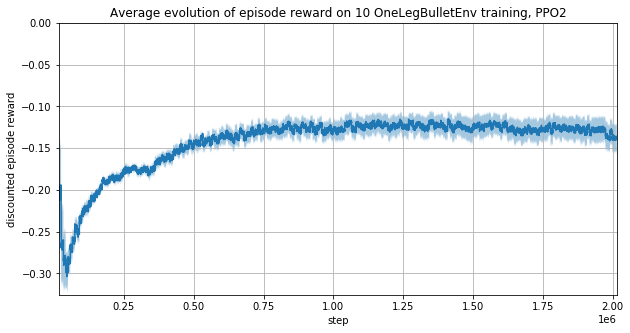

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("./tensorboard_log/doc3/aggregates/input_info_discounted_rewards.csv", index_col=0)
step = df["std"].index
mean = df["mean"].values
err = df["std"].values/np.sqrt(10)

# Plot data
plt.figure(figsize=(10,5))
plt.fill_between(step, mean - err, mean + err, alpha=.4)
plt.plot(step, mean)
plt.xlabel("step")
plt.ylabel("discounted episode reward")
plt.title("Average evolution of episode reward on 10 OneLegBulletEnv training, PPO2")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()
plt.xlim(step[0], step[-1])
plt.ylim(min(mean - err), 0)
plt.show()